In [1]:
# calculations/order_parameter.py

import numpy as np
from ase import Atoms
from scipy.spatial import cKDTree

def calculate_order_parameter(structure: Atoms, center_type: int = 0, relative_type: int = 3) -> np.ndarray:
    """
    Calculate the order parameter for atoms of center_type by finding the
    minimum distance to the nearest symmetry-related positions of relative_type atoms.
    Only considers 2D positions (x and y coordinates).

    Parameters:
        structure (Atoms): The atomic structure.
        center_type (int): The atom type for which to calculate the order parameter.
        relative_type (int): The atom type to calculate the order parameter relative to.

    Returns:
        np.ndarray: Array of order parameters for center_type atoms.
    """
    positions = structure.get_positions()[:, :2]  # Only consider x and y coordinates
    atom_types = structure.arrays['atom_types']
    cell = structure.get_cell()[:2, :2]  # Only consider x and y components of cell vectors

    # Filter atom types
    center_indices = np.where(atom_types == center_type)[0]
    relative_indices = np.where(atom_types == relative_type)[0]

    center_positions = positions[center_indices]
    relative_positions = positions[relative_indices]

    # Define translation vectors for nearest neighbors and other symmetry-related shifts
    translation_vectors = np.array([
        [0, 0],
        cell[0], cell[1],
        cell[0] + cell[1],
        -cell[0], -cell[1],
        -cell[0] - cell[1]
    ])

    # Build KDTree for efficient nearest neighbor search
    tree = cKDTree(relative_positions)

    # Calculate nearest neighbor distances for all center atoms
    distances, _ = tree.query(center_positions, k=1)

    # Calculate symmetry-related distances using broadcasting
    symmetry_distances = np.linalg.norm(center_positions[:, None, None] - (relative_positions[None, :, None] + translation_vectors[None, None, :]), axis=-1)

    # Find minimum distances across all symmetry-related positions
    min_distances = np.min(symmetry_distances, axis=(1, 2))

    # Calculate order parameters as the difference between actual and ideal positions
    order_parameters = np.abs(min_distances)

    return order_parameters

# calculate_order_parameter(unrelaxed, 0, 3)



In [61]:
# calculations/disregistry.py

import numpy as np
from ase import Atoms

def mod_gamma(v, gamma_lattice):
    """Reduces a vector v modulo the lattice defined by gamma_lattice."""
    coeffs = np.linalg.solve(gamma_lattice.T, v)
    coeffs = coeffs % 1
    return np.dot(gamma_lattice.T, coeffs)

def unit_range_fixed(x, L=1, eps=1e-9):
    y = x.copy()
    y = y % L
    y[(np.fabs(y) < eps) | (np.fabs(L - y) < eps)] = 0
    return y

def calculate_disregistry(structure: Atoms, A1: np.ndarray, A2: np.ndarray) -> tuple:
    """
    Calculate disregistry vectors for atom_types == 0 and atom_types == 3 atoms
    with respect to the top and bottom layer primitive unit cells.

    Parameters:
        relaxed (Atoms): The relaxed atomic structure.
        A1 (np.ndarray): Primitive unit cell vectors for layer 1.
        A2 (np.ndarray): Primitive unit cell vectors for layer 2.

    Returns:
        tuple: (b1, b2) Disregistry vectors for atom_types == 3 and atom_types == 0 atoms.
    """
    positions = structure.get_positions()[:, :2]
    atom_types = structure.arrays['atom_types']

    ad1 = np.eye(2) - A2 @ np.linalg.inv(A1)
    ad2 = np.eye(2) - A1 @ np.linalg.inv(A2)
    
     

    layer1_mask = atom_types == 0
    layer2_mask = atom_types == 3

    b1 = (ad1 @ positions[layer1_mask].T).T
    b2 = (ad2 @ positions[layer2_mask].T).T

    b1 = unit_range_fixed(b1 @ np.linalg.inv(A2)) @ A2
    b2 = unit_range_fixed(b2 @ np.linalg.inv(A1)) @ A1

    return b1, b2

# Example usage:
b1_unrelaxed, b2_unrelaxed = calculate_disregistry(unrelaxed, A1, A2)
b1_relaxed, b2_relaxed = calculate_disregistry(relaxed, A1, A2)


In [50]:
periodic_2_unrelaxed = unit_range_fixed(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,:2] @ np.linalg.inv(A2)) @ A2
periodic_2_relaxed = unit_range_fixed(relaxed.get_positions()[relaxed.arrays['atom_types'] == 3,:2] @ np.linalg.inv(A2)) @ A2

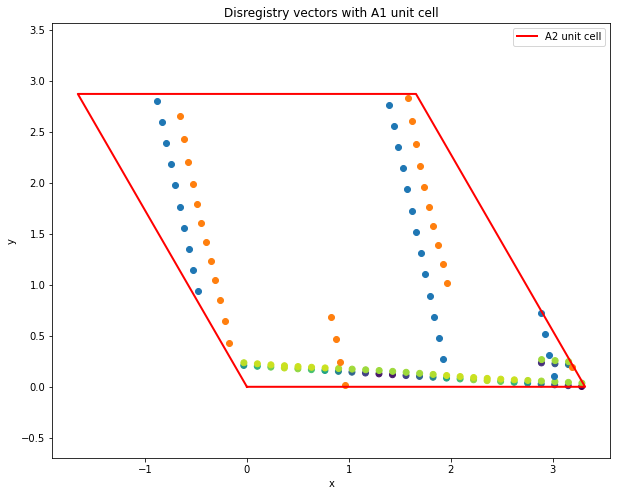

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

# unrelaxed_positions = unrelaxed.positions[unrelaxed.arrays['atom_types'] == 0, :2]
# relaxed_positions = relaxed.positions[relaxed.arrays['atom_types'] == 0, :2]
# ad1 = np.eye(2) - A2.T @ np.linalg.inv(A1.T)
# b1_unrelaxed = (ad1 @ unrelaxed_positions.T).T
# b1_relaxed = (ad1 @ relaxed_positions.T).T

plt.figure(figsize=(10, 8))
plt.scatter(b1_unrelaxed[:,0], b1_unrelaxed[:,1], c=unrelaxed_order_param, vmin=0, vmax=1.8)
plt.scatter(b1_relaxed[:,0], b1_relaxed[:,1], c=relaxed_order_param, vmin=0, vmax=1.8)

plt.scatter(periodic_2_unrelaxed[:,0], periodic_2_unrelaxed[:,1])
plt.scatter(periodic_2_relaxed[:,0], periodic_2_relaxed[:,1])

# Add lines representing the unit cell A1 as a full polygon
origin = np.array([0, 0])
vertices = np.array([origin, A2[0], A2[0] + A2[1], A2[1], origin])
plt.plot(vertices[:, 0], vertices[:, 1], 'r-', linewidth=2, label='A2 unit cell')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Disregistry vectors with A1 unit cell')
plt.axis('equal')
plt.show()

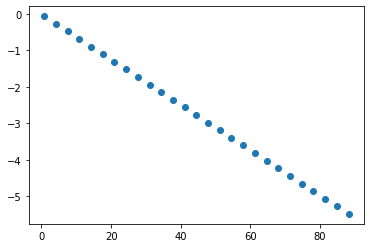

In [75]:
# (unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,:2] @ np.linalg.inv(A2)) @ A2
np.set_printoptions(precision=2, suppress=True)
# plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0,:2] @ np.linalg.inv(A1))
plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,0], unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3,1])


In [6]:
def plot_order_parameter_along_spline(relaxed: Atoms, order_parameter: np.ndarray, num_points: int = 1000):
    """
    Plot the order parameter along a cubic spline path through atom_types == 0 atoms,
    with the line colored according to the magnitude of the order parameter.

    Parameters:
        relaxed (Atoms): The relaxed atomic structure.
        order_parameter (np.ndarray): Array of order parameters.
        num_points (int): Number of points to interpolate along the spline.
    """
    positions = relaxed.get_positions()
    atom_types = relaxed.arrays['atom_types']
    
    # Filter atom_types == 0
    type0_indices = np.where(atom_types == 0)[0]
    type0_positions = positions[type0_indices]
    type0_order_param = order_parameter
    
    # Sort atoms by x-coordinate to create a path
    sorted_indices = np.argsort(type0_positions[:, 0])
    sorted_positions = type0_positions[sorted_indices]
    sorted_order_param = type0_order_param[sorted_indices]
    
    # Calculate atom distances
    atom_distances = np.cumsum(np.sqrt(np.sum(np.diff(sorted_positions, axis=0)**2, axis=1)))
    atom_distances = np.insert(atom_distances, 0, 0)  # Add starting point
    
    # Create cubic spline through atom positions
    tck, u = splprep([sorted_positions[:, 0], sorted_positions[:, 1]], s=0, k=3)
    
    # Interpolate points along the spline
    spline_points = np.linspace(0, 1, num_points)
    interpolated_positions = np.array(splev(spline_points, tck)).T
    
    # Calculate cumulative distance along the spline
    distances = np.cumsum(np.sqrt(np.sum(np.diff(interpolated_positions, axis=0)**2, axis=1)))
    distances = np.insert(distances, 0, 0)  # Add starting point
    
    # Create RBF interpolation for order parameter
    rbf = Rbf(sorted_positions[:, 0], sorted_positions[:, 1], sorted_order_param, function='multiquadric')
    interpolated_order_param = rbf(interpolated_positions[:, 0], interpolated_positions[:, 1])
    
    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot interpolated order parameter with color
    points = ax1.scatter(distances, interpolated_order_param, c=interpolated_order_param, cmap='viridis', s=5, vmin=0, vmax=1.8)
    fig.colorbar(points, ax=ax1, label='Order Parameter')
    
    # Plot actual values
    ax1.scatter(atom_distances, sorted_order_param, color='red', s=30, zorder=3, label='Actual Values')
    
    ax1.set_ylim(0, 1.8)
    ax1.set_xlabel('Distance along path (Å)')
    ax1.set_ylabel('Order Parameter')
    ax1.legend()
    
    # Create secondary x-axis for atom positions
    ax2 = ax1.twiny()
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_xticks(atom_distances)
    ax2.set_xticklabels([])
    
    # Add vertical lines for atom positions
    for dist in atom_distances:
        ax1.axvline(x=dist, color='gray', alpha=0.3, linestyle='--')
    
    plt.title('Order Parameter Along Cubic Spline Path')
    
    plt.tight_layout()
    plt.show()

# Usage example:
plot_order_parameter_along_spline(relaxed, relaxed_order_param)
plot_order_parameter_along_spline(unrelaxed, unrelaxed_order_param)

NameError: name 'relaxed_order_param' is not defined

In [7]:
def plot_order_parameter_top_down(relaxed: Atoms, order_parameter: np.ndarray, grid_size: int = 200):
    """
    Plot a top-down view of the lattice with interpolated order parameter as background
    and vertical gray lines at each atom's x-position.

    Parameters:
        relaxed (Atoms): The relaxed atomic structure.
        order_parameter (np.ndarray): Array of order parameters.
        grid_size (int): Resolution of the interpolation grid.
    """
    positions = relaxed.get_positions()
    atom_types = relaxed.arrays['atom_types']
    
    # Filter atom_types == 0
    type0_indices = np.where(atom_types == 0)[0]
    type0_positions = positions[type0_indices]
    type0_order_param = order_parameter
    
    x, y = type0_positions[:, 0], type0_positions[:, 1]
    
    # RBF interpolation
    rbf = Rbf(x, y, type0_order_param, function='multiquadric', smooth=0.1)
    xi = np.linspace(x.min(), x.max(), grid_size)
    yi = np.linspace(y.min(), y.max(), grid_size)
    xi, yi = np.meshgrid(xi, yi)
    zi = rbf(xi, yi)
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(zi, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis', alpha=0.6, vmin=0, vmax=1.8)
    plt.colorbar(im, label='Order Parameter', fraction=0.01, pad=0.04)
    
    # Plot atom_types == 0 atoms
    ax.scatter(type0_positions[:, 0], type0_positions[:, 1], c='red', s=10, label='Type 0 Atoms')
    
    # Add vertical gray lines at each atom's x-position
    for x_pos in type0_positions[:, 0]:
        ax.axvline(x=x_pos, color='gray', alpha=0.3, linestyle='--')
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Top-Down View of Order Parameter')
    ax.legend()
    plt.tight_layout()
    plt.show()

# Example usage
plot_order_parameter_top_down(relaxed, relaxed_order_param)
plot_order_parameter_top_down(unrelaxed, unrelaxed_order_param)

NameError: name 'Rbf' is not defined

In [8]:
# plots/disregistry_plots.py

import numpy as np
import matplotlib.pyplot as plt

def plot_disregistry_scatter(disregistry: np.ndarray):
    """
    Plot a scatter plot of disregistry vectors on the configuration space grid.

    Parameters:
        disregistry (np.ndarray): Disregistry vectors for atom_types == 0 atoms.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(disregistry[:, 0], disregistry[:, 1], c='blue', s=10, alpha=0.6)
    plt.xlabel('Displacement along A2[0]')
    plt.ylabel('Displacement along A2[1]')
    plt.title('Disregistry Scatter Plot')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
# example usage
plot_disregistry_scatter(b1_unrelaxed)
plot_disregistry_scatter(b1_relaxed)

NameError: name 'b1_unrelaxed' is not defined

In [8]:
# main.py

import numpy as np
from ase.io import read
# from calculations.order_parameter import calculate_order_parameter
# from calculations.disregistry import calculate_disregistry
# from plots.order_parameter_plots import plot_order_parameter_cut, plot_order_parameter_top_down
# from plots.disregistry_plots import plot_disregistry_scatter


# File paths (replace with your actual file paths)
unrelaxed_file = 'MoS2_WSe2_1D.xyz'
relaxed_file = 'MoS2_WSe2_1D_lammps.traj.xyz'

# Read structures
unrelaxed = read(unrelaxed_file, index= 0)
relaxed = read(relaxed_file, index= -1)
relaxed.arrays['atom_types'] = unrelaxed.arrays['atom_types']

# # Calculate order parameter
unrelaxed_order_param = calculate_order_parameter(unrelaxed, 0, 3)
relaxed_order_param = calculate_order_parameter(relaxed, 0, 3)

# # Plot order parameter cut along x-axis (axis=0)
# plot_order_parameter_along_spline(unrelaxed, unrelaxed_order_param)
# plot_order_parameter_along_spline(relaxed, relaxed_order_param)

# # # Plot top-down view of order parameter
# plot_order_parameter_top_down(unrelaxed, unrelaxed_order_param)
# plot_order_parameter_top_down(relaxed, relaxed_order_param)

# # Define A1 and A2 unit cells (replace with your actual unit cell matrices)
def convert_string_to_array(string):
    # Remove brackets and split the string into components
    return np.array([float(x) for x in string.strip('[]').split()]).reshape(2,2)
A1 = convert_string_to_array(unrelaxed.info['base_lattice_0'])
A2 = convert_string_to_array(unrelaxed.info['base_lattice_1'])

# # Calculate disregistry vectors
disregistry_relaxed = calculate_disregistry(relaxed, A1, A2)
disregistry_unrelaxed = calculate_disregistry(unrelaxed, A1, A2)

# # Plot disregistry scatter
# plot_disregistry_scatter(disregistry)

In [27]:
npA2

array([[ 3.319 ,  0.    ],
       [-1.6595,  2.8743]])

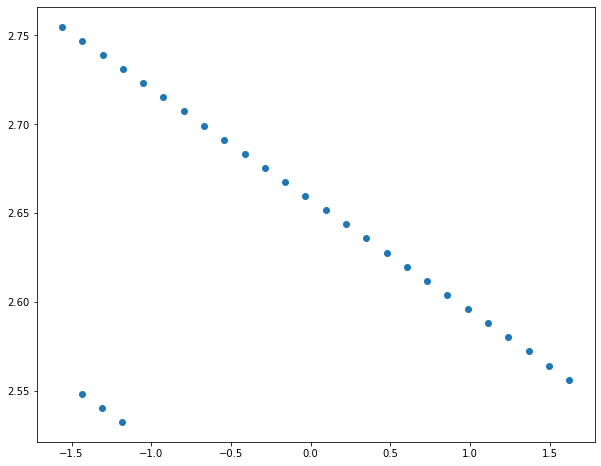

In [26]:
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.scatter(disregistry_unrelaxed[1][:,0], disregistry_unrelaxed[1][:,1])


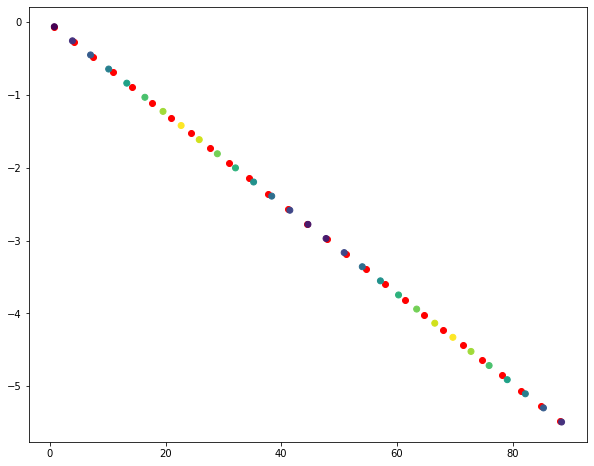

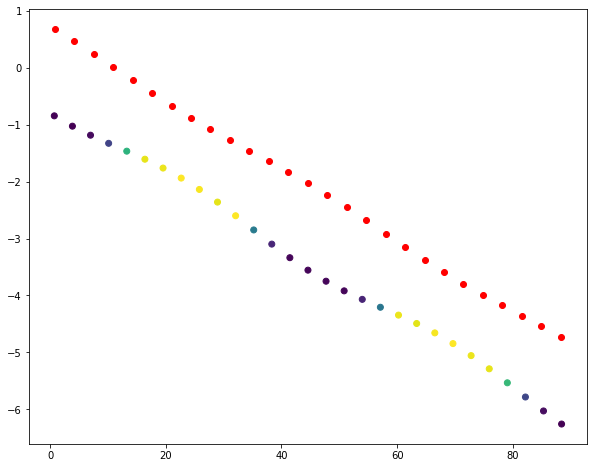

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3, 0],
            unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 3, 1], c='red')
plt.scatter(unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0, 0],
            unrelaxed.get_positions()[unrelaxed.arrays['atom_types'] == 0, 1], c=unrelaxed_order_param)

plt.figure(figsize=(10, 8))
plt.scatter(relaxed.get_positions()[relaxed.arrays['atom_types'] == 3, 0],
            relaxed.get_positions()[relaxed.arrays['atom_types'] == 3, 1], c='red')
plt.scatter(relaxed.get_positions()[relaxed.arrays['atom_types'] == 0, 0],
            relaxed.get_positions()[relaxed.arrays['atom_types'] == 0, 1], c=relaxed_order_param)


array([[ 8.84107336e+01, -6.25800084e+00,  2.77075868e+01],
       [ 4.15532954e+01, -1.48173163e+00,  2.92551172e+01],
       [ 4.15589947e+01, -1.47727083e+00,  2.61538929e+01],
       [ 8.52853648e+01, -6.02825915e+00,  2.77018858e+01],
       [ 3.84294924e+01, -1.24251882e+00,  2.92517087e+01],
       [ 3.84286823e+01, -1.23860683e+00,  2.61505327e+01],
       [ 8.21609998e+01, -5.78323358e+00,  2.77027244e+01],
       [ 3.53109630e+01, -9.92638020e-01,  2.92587911e+01],
       [ 3.52971052e+01, -9.89937660e-01,  2.61576054e+01],
       [ 7.90361776e+01, -5.53365440e+00,  2.77166314e+01],
       [ 3.21918123e+01, -7.41732370e-01,  2.92799281e+01],
       [ 3.21651485e+01, -7.41073620e-01,  2.61791569e+01],
       [ 7.59079887e+01, -5.28784923e+00,  2.77438311e+01],
       [ 7.42912702e+01, -6.12093408e+00,  2.93089347e+01],
       [ 7.42632582e+01, -6.12294321e+00,  2.62086349e+01],
       [ 7.27752184e+01, -5.05595814e+00,  2.77723032e+01],
       [ 7.11531923e+01, -5.89705056e+00